In [1]:
from simulation import  *

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import matplotlib.cm

In [17]:
length = 3
timesteps = 4 # Resolution for timesteps and weights
window_size = 2
num_neurons = 60 # Number of excitatory neurons in the column
threshold = 8 # Firing threshold for every excitatory neuron
rf_size = window_size*2
inchannels = 1


simulation = Simulation()
corpus = Corpus()
sentences = simulation.construct_sentences()
tokens = corpus.tokenize(sentences)



corpus.dictionary.get_encoding(length,timesteps)
spike_data = SpikeData(tokens, sentences, corpus)
spike_input, spike_output = spike_data.convert_tokens(window_size)

temporal_transform = utils.Intensity2Latency(timesteps)

def getContext(word):
    idx = corpus.dictionary.word2idx[word]
    enc = corpus.dictionary.idx2spike[idx]
    context = spike_input[np.all(spike_output == enc, axis=1)]
    print(context.shape)
    context = torch.from_numpy(context)
    context = temporal_transform(context)
    return context.sign()

def getContext2(word):
    idx = corpus.dictionary.word2idx[word]
    enc = corpus.dictionary.idx2spike[idx]
    context = spike_input[np.all(spike_output == enc, axis=1)]
    rev = np.array([(3-s) for s in context])
    comb = np.stack([context, rev])
    context = torch.from_numpy(comb)
    context = temporal_transform(context) #[4, 2, 480, 4, 3]
    return context.sign()

cat_context = getContext('cat')
dog_context = getContext('dog')
sit_context = getContext('sits')
eat_context = getContext('eats')


class DatasetContext(Dataset):
    def __init__(self, context, transform=None):
        self.data = context
        
    def __len__(self):
        return self.data.size(1)
    
    def __getitem__(self, index):
        image = self.data[:,index,:,:].reshape((self.data.size(0),1, self.data.size(2), -1))        
        return image

class DatasetContext2(Dataset):
    def __init__(self, context, transform=None):
        self.data = context
        
    def __len__(self):
        return self.data.size(2)
    
    def __getitem__(self, index):
        image = self.data[:,:,index,:,:].reshape((self.data.size(0),2, self.data.size(3), -1))        
        return image


(480, 4, 3)
(480, 4, 3)
(480, 4, 3)
(480, 4, 3)


In [3]:
cat_context2 = getContext2('cat')
dog_context2 = getContext2('dog')
sit_context2 = getContext2('sits')
eat_context2 = getContext2('eats')
cat_context1 = getContext('cat')
dog_context1 = getContext('dog')
sit_context1 = getContext('sits')
eat_context1 = getContext('eats')


In [4]:
expect = torch.zeros(40)
print(expect)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [5]:

class Column(nn.Module):
    def __init__(self, num_neurons, threshold, kwta, inhibition_radius):
        super(Column, self).__init__()
        self.k = num_neurons
        self.thresh = threshold
        self.kwta = kwta
        self.inhibition_radius = inhibition_radius
        self.ec = snn.LocalConvolution(input_size=(rf_size,length),
                                       in_channels=inchannels,
                                       out_channels=self.k,
                                       kernel_size=(rf_size,length),
                                       stride=1)
        self.stdp = snn.ModSTDP(self.ec, 10/128, 10/128, 1/128, 96/128, 4/128, maxweight = timesteps)

    def forward(self, rec_field):
        out = self.ec(rec_field)
        spike, pot = sf.fire(out, self.thresh, True)
        winners = sf.get_k_winners(pot, kwta = self.kwta, inhibition_radius = self.inhibition_radius)
        coef = torch.zeros_like(out)
        coef[:,winners,:,:] = 1
        return torch.mul(pot, coef).sign()
    
 

In [26]:

### Column Initialization ###

MyColumn = Column(num_neurons, threshold, num_neurons, 0)
    
cat = DatasetContext(cat_context1)
trainLoader = DataLoader(cat, batch_size=1000, shuffle=True)
print(spike_input.shape)

# expect = torch.zeros(( 30,2))
# expect[10,:] = 3
# expect[20] = 2
# expect = temporal_transform(expect)
# print(expect.size())


num_epochs = 40
result = torch.zeros(num_epochs*cat.__len__(), num_neurons)
for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader):
        for i in range(len(data)):
            out = MyColumn(data[i])
            result[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)

  0%|          | 0/1 [00:00<?, ?it/s]

(33600, 4, 3)
torch.Size([4, 30, 2])
torch.Size([4, 1, 4, 3])
torch.Size([4, 60, 1, 1])


RuntimeError: The size of tensor a (30) must match the size of tensor b (60) at non-singleton dimension 0

(19200, 60)
(19200, 60)
tensor(13.)


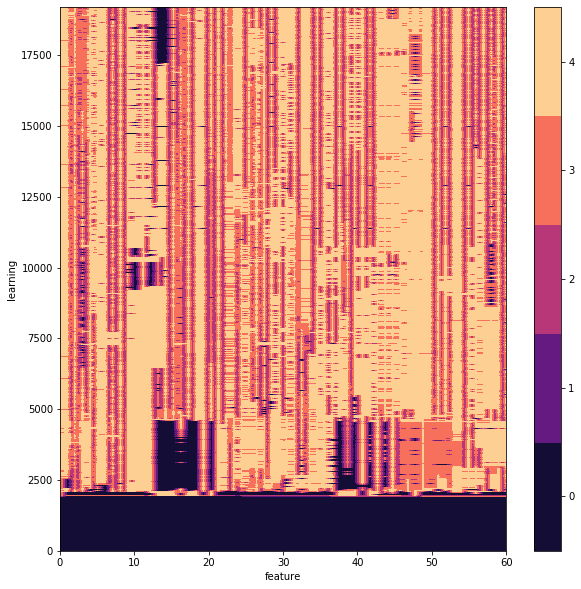

In [30]:
X = np.linspace(0, result.size(1),result.size(1))
Y = np.linspace(0, result.size(0),result.size(0))
X, Y = np.meshgrid(X, Y)

plt.figure(figsize = (10,10))

plt.contourf(X, Y, result.numpy(), [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap='magma')
plt.colorbar(ticks=range(5))
plt.ylabel("learning")
plt.xlabel("feature")
# ax.plot_surface(X,Y,result.numpy())
print(result.numpy().shape)
print(X.shape)

result[result<4] = 0
result[result==4] = 1
four = torch.sum(result, dim = 1)
print(torch.max(four))

In [34]:

### Column Initialization ###

MyColumn = Column(num_neurons, threshold, 12, 0)
    
cat = DatasetContext2(cat_context2)
trainLoader = DataLoader(cat, batch_size=1000, shuffle=True)

num_epochs = 40
result = torch.zeros(num_epochs*cat.__len__(), num_neurons)
for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader):
        for i in range(len(data)):
            out = MyColumn(data[i])
            result[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)

  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.48647403717041016


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.4781181812286377


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.5727298259735107


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6722910404205322


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6240952014923096


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6297061443328857


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6579301357269287


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6791660785675049


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6775557994842529


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6662681102752686


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6739871501922607


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6161887645721436


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6292839050292969


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6254730224609375


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6720221042633057


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.638153076171875


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6754980087280273


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.7408430576324463


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6210598945617676


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.64640212059021


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6626739501953125


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6904623508453369


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6886930465698242


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.691054105758667


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6854960918426514


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6472499370574951


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6871700286865234


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6707749366760254


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6580560207366943


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.616804838180542


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.683168888092041


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6753940582275391


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.67159104347229


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.645658016204834


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6820721626281738


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.66172194480896


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6561620235443115


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.7539148330688477


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6252431869506836


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

Training done under  0.6876909732818604


(19200, 60)
(19200, 60)
tensor(13.)


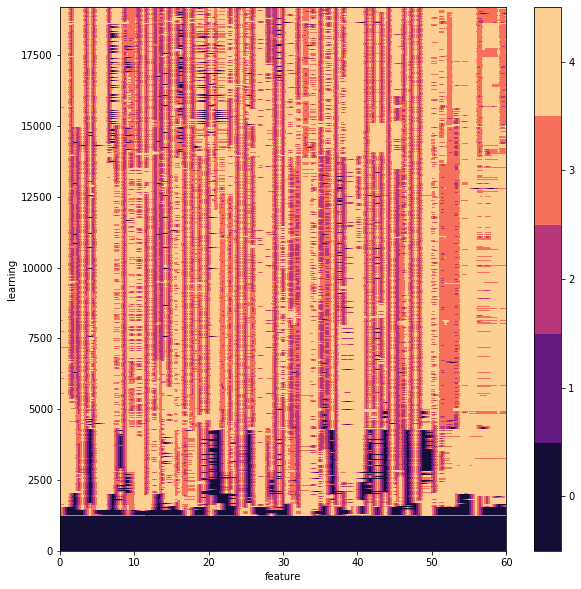

In [35]:
X = np.linspace(0, result.size(1),result.size(1))
Y = np.linspace(0, result.size(0),result.size(0))
X, Y = np.meshgrid(X, Y)

plt.figure(figsize = (10,10))

plt.contourf(X, Y, result.numpy(), [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap='magma')
plt.colorbar(ticks=range(5))
plt.ylabel("learning")
plt.xlabel("feature")
# ax.plot_surface(X,Y,result.numpy())
print(result.numpy().shape)
print(X.shape)

result[result<4] = 0
result[result==4] = 1
four = torch.sum(result, dim = 1)
print(torch.max(four))

(7200, 60)
[2. 0. 3. 0. 3. 0. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 3. 3. 0.
 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


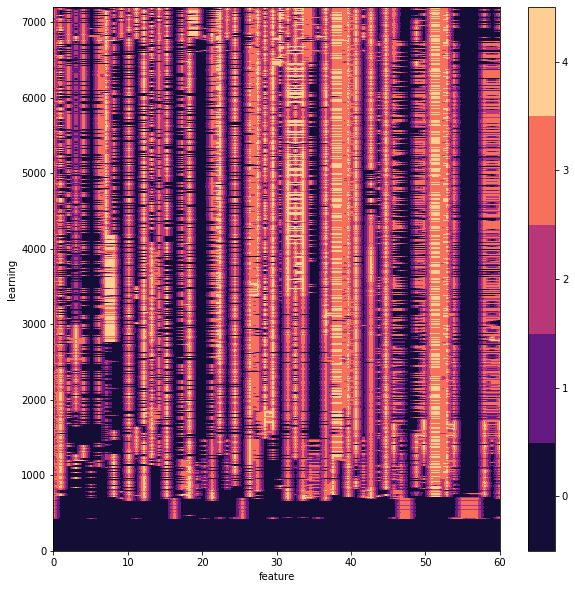

In [253]:
X = np.linspace(0, result2.size(1),result2.size(1))
Y = np.linspace(0, result2.size(0),result2.size(0))
X, Y = np.meshgrid(X, Y)

plt.figure(figsize = (10,10))

plt.contourf(X, Y, result2.numpy(), [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap='magma')
plt.colorbar(ticks=range(5))
plt.ylabel("learning")
plt.xlabel("feature")
# ax.plot_surface(X,Y,result.numpy())
print(result2.numpy().shape)
print(result2.numpy()[-1,:])


In [254]:
print(result2.numpy()[-2,:])
print(result2.numpy()[-3,:])
print(result2.numpy()[-4,:])

print(result2.numpy()[0,:])


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0.
 0. 0. 0. 0. 0. 0. 4. 3. 0. 3. 3. 0. 3. 0. 0. 0. 3. 0. 0. 0. 0. 3. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[2. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 3. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 3. 0. 0. 0.
 0. 0. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0.]
[3. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 4. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 4.
 0. 0. 4. 0. 0. 0. 0. 4. 0. 4. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [262]:
temporal_transform = utils.Intensity2Latency(timesteps)

### Column Initialization ###

MyColumn = Column(num_neurons, threshold, 8, 0)
    
cat = DatasetContext(cat_context)
sit = DatasetContext(sit_context)

trainLoader1 = DataLoader(cat, shuffle=True)
trainLoader2 = DataLoader(sit, shuffle = True)

num_epochs = 20
result1 = torch.zeros(num_epochs*(cat.__len__()), num_neurons)
result2 = torch.zeros(num_epochs*(sit.__len__()), num_neurons)
result3 = torch.zeros(num_epochs*(cat.__len__()), num_neurons)

for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader1):
        for i in range(len(data)):
            out = MyColumn(data[i])
            result1[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)

for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader2):
        for i in range(len(data)):
            out = MyColumn(data[i])
            result2[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)

for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader1):
        for i in range(len(data)):
            out = MyColumn(data[i])
            result3[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)

  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.4917280673980713


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.5074489116668701


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.4801828861236572


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.49019384384155273


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.5394160747528076


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.563910961151123


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6143879890441895


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.5826928615570068


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6634178161621094


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6291899681091309


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6425268650054932


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.5939180850982666


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6089253425598145


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.5880320072174072


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6527979373931885


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6275691986083984


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6447291374206543


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6324269771575928


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.5980868339538574


 15%|█▌        | 74/480 [00:00<00:00, 732.80it/s]

Training done under  0.6153059005737305


 15%|█▍        | 71/480 [00:00<00:00, 701.16it/s]

Training done under  0.6788740158081055


 15%|█▌        | 72/480 [00:00<00:00, 712.67it/s]

Training done under  0.6848452091217041


 15%|█▍        | 71/480 [00:00<00:00, 709.83it/s]

Training done under  0.672598123550415


 31%|███▏      | 151/480 [00:00<00:00, 739.04it/s]

Training done under  0.6657516956329346


 16%|█▌        | 76/480 [00:00<00:00, 757.86it/s]

Training done under  0.6387710571289062


 30%|███       | 145/480 [00:00<00:00, 721.12it/s]

Training done under  0.6586108207702637


 15%|█▌        | 72/480 [00:00<00:00, 712.83it/s]

Training done under  0.6742870807647705


 15%|█▌        | 73/480 [00:00<00:00, 721.02it/s]

Training done under  0.6626572608947754


 15%|█▌        | 73/480 [00:00<00:00, 721.34it/s]

Training done under  0.6579630374908447


 15%|█▌        | 73/480 [00:00<00:00, 729.07it/s]

Training done under  0.626410961151123


 15%|█▌        | 73/480 [00:00<00:00, 728.56it/s]

Training done under  0.6657431125640869


 15%|█▌        | 72/480 [00:00<00:00, 715.97it/s]

Training done under  0.6626718044281006


 15%|█▍        | 70/480 [00:00<00:00, 698.51it/s]

Training done under  0.6750190258026123


 30%|███       | 146/480 [00:00<00:00, 721.33it/s]

Training done under  0.6629672050476074


 15%|█▌        | 72/480 [00:00<00:00, 719.93it/s]

Training done under  0.6608390808105469


 31%|███       | 147/480 [00:00<00:00, 726.69it/s]

Training done under  0.6636416912078857


 30%|███       | 145/480 [00:00<00:00, 718.02it/s]

Training done under  0.6640810966491699


 15%|█▌        | 74/480 [00:00<00:00, 739.07it/s]

Training done under  0.6691610813140869


 15%|█▌        | 73/480 [00:00<00:00, 727.50it/s]

Training done under  0.6584539413452148


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6601052284240723


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6315000057220459


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.5932221412658691


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.628403902053833


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6231441497802734


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6112933158874512


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6571180820465088


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6623120307922363


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6587660312652588


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6348862648010254


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6150729656219482


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6323189735412598


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.635962724685669


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6035878658294678


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6143620014190674


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6193318367004395


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.5998311042785645


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.60782790184021


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.636970043182373


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.6377630233764648


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

Training done under  0.6203100681304932


(28800, 60)


Text(0.5, 0, 'feature')

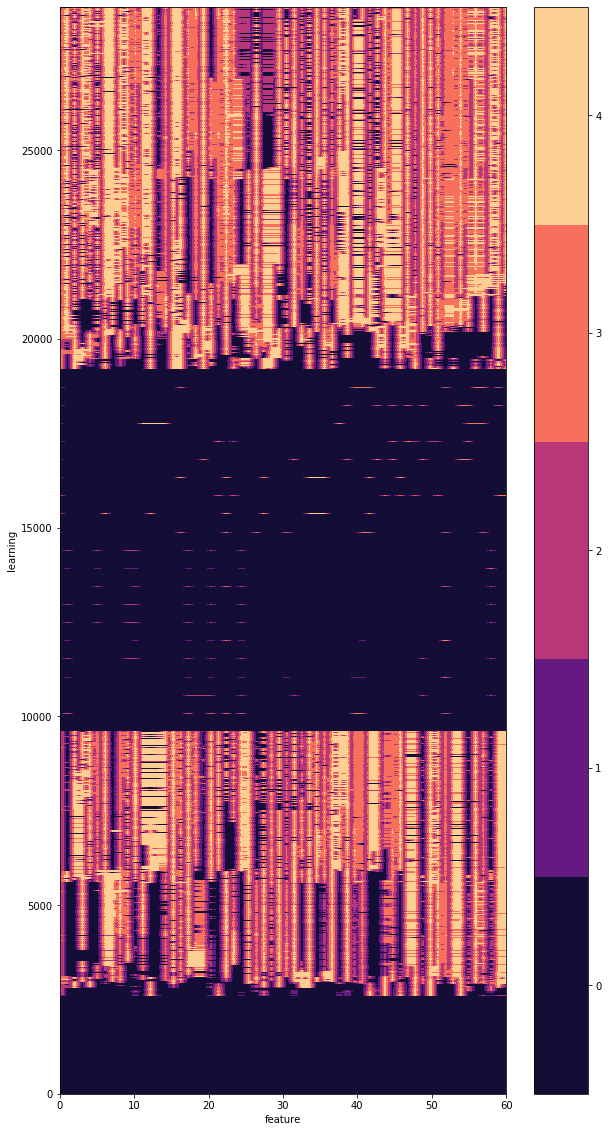

In [266]:
Z = np.concatenate((result1.numpy(), result2.numpy(), result3.numpy()), axis=0)
print(Z.shape)
X = np.linspace(0, Z.shape[1],Z.shape[1])
Y = np.linspace(0, Z.shape[0],Z.shape[0])
X, Y = np.meshgrid(X, Y)

plt.figure(figsize = (10,20))

plt.contourf(X, Y, Z, [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap='magma')
plt.colorbar(ticks=range(5))
plt.ylabel("learning")
plt.xlabel("feature")